In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from htorch import layers
import time

In [2]:
device = torch.device('cuda:0')

data = torch.tensor(pd.read_csv("../data/mnist/train.csv", header=None).values)
x, y = (data[:, 1:]/255).float().to(device), torch.nn.functional.one_hot(data[:, 0].long(), 10).to(device)

test = torch.tensor(pd.read_csv("../data/mnist/test.csv", header=None).values)
x_test, y_test = (test[:, 1:]/255).float().to(device), torch.nn.functional.one_hot(test[:, 0].long(), 10).to(device)

In [3]:
class Real(nn.Module): 
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 300)
        self.fc2 = nn.Linear(300, 100)
        self.fc4 = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc4(x)
        return x
real_model = Real()
real_model.to(device)
optimiser = torch.optim.Adam(real_model.parameters(), lr=1.2e-3)

In [4]:
class Quat(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = layers.QLinear(196, 75)
        self.fc2 = layers.QLinear(75, 25)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
        # x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
quat_model = Quat()
quat_model.to(device)
optimiser = torch.optim.Adam(quat_model.parameters(), lr=1.2e-3)

for batch_size in [2**(i) for i in range(5, 14)][::-1]:
    for model in ["real", "quat"]:
        if model == "quat":
            model = Quat()
            model.to(device)
            optimiser = torch.optim.Adam(model.parameters(), lr=1.2e-3)
        elif model == "real":
            model = Real()
            model.to(device)
            optimiser = torch.optim.Adam(model.parameters(), lr=1.2e-3)

        t_f = 0
        t_b = 0

        for epoch in tqdm(range(1000)):
            for i in range(0, len(x), batch_size):
                batch_x, batch_y = x[i:i+batch_size], y[i:i+batch_size].float()
                optimiser.zero_grad()

                t0 = time.time()
                output = model(batch_x)
                t_f += time.time() - t0

                t0 = time.time()
                loss = F.mse_loss(output, batch_y)
                loss.backward()
                t_b += time.time() - t0

                optimiser.step()
            # losses.append(loss.item())
        if isinstance(model, Real):
            message = f"""<tr>
            <td rowspan="2"><b>{batch_size}</b></td>
            <td><b>Real</b></td>
            <td>{t_f:.3f}ms</td>
            <td>{t_b:.3f}ms</td>
            </tr>"""
        else:
            message = f"""<tr>
            <td><b>Quat</b></td>
            <td>{t_f:.3f}ms</td>
            <td>{t_b:.3f}ms</td>
            </tr>"""
        print(message)


In [5]:
batchsizes = []
real_accuracies = [[],[]] #test and train
quat_accuracies = [[],[]]

# for batch_size in [i for i in range(5, 14)]:
for batch_size in [32, 64, 100, 150, 200, 250, 300, 350, 400, 450, 500]:
    batchsizes.append(batch_size)
    for model in ["real", "quat"]:
        if model == "quat":
            model = Quat()
            model.to(device)
            optimiser = torch.optim.Adam(model.parameters(), lr=1.2e-3)
        elif model == "real":
            model = Real()
            model.to(device)
            optimiser = torch.optim.Adam(model.parameters(), lr=1.2e-3)
        
        # t_f = 0
        # t_b = 0
        
        print(f"batchsize: {batch_size} model: {model.__class__.__name__}", end=" ")
        
        for epoch in tqdm(range(200)):
            for i in range(0, len(x), batch_size):
                batch_x, batch_y = x[i:i+batch_size], y[i:i+batch_size].float()
                optimiser.zero_grad()
                
                # t0 = time.time()
                output = model(batch_x)
                # t_f += time.time() - t0
                
                # t0 = time.time()
                loss = F.mse_loss(output, batch_y)
                loss.backward()
                # t_b += time.time() - t0

                optimiser.step()
            # losses.append(loss.item())
        if isinstance(model, Real):
            real_accuracies[0].append((model(x).argmax(1) == y.argmax(1)).sum().item()*100/len(x))
            real_accuracies[1].append((model(x_test).argmax(1) == y_test.argmax(1)).sum().item()*100/len(x_test))
        else:
            quat_accuracies[0].append((model(x).argmax(1) == y.argmax(1)).sum().item()*100/len(x))
            quat_accuracies[1].append((model(x_test).argmax(1) == y_test.argmax(1)).sum().item()*100/len(x_test))

batchsize: 8192 model: Real 

100%|██████████| 250/250 [00:02<00:00, 115.06it/s]


batchsize: 8192 model: Quat 

100%|██████████| 250/250 [00:02<00:00, 109.07it/s]


batchsize: 4096 model: Real 

100%|██████████| 250/250 [00:02<00:00, 104.24it/s]


batchsize: 4096 model: Quat 

100%|██████████| 250/250 [00:03<00:00, 81.10it/s]


batchsize: 2048 model: Real 

100%|██████████| 250/250 [00:03<00:00, 77.62it/s]


batchsize: 2048 model: Quat 

100%|██████████| 250/250 [00:06<00:00, 41.01it/s]


batchsize: 1024 model: Real 

100%|██████████| 250/250 [00:05<00:00, 48.52it/s]


batchsize: 1024 model: Quat 

100%|██████████| 250/250 [00:11<00:00, 21.04it/s]


batchsize: 512 model: Real 

100%|██████████| 250/250 [00:10<00:00, 23.90it/s]


batchsize: 512 model: Quat 

100%|██████████| 250/250 [00:23<00:00, 10.46it/s]


batchsize: 256 model: Real 

100%|██████████| 250/250 [00:21<00:00, 11.87it/s]


batchsize: 256 model: Quat 

100%|██████████| 250/250 [00:47<00:00,  5.23it/s]


batchsize: 128 model: Real 

100%|██████████| 250/250 [00:41<00:00,  5.98it/s]


batchsize: 128 model: Quat 

100%|██████████| 250/250 [01:34<00:00,  2.64it/s]


batchsize: 64 model: Real 

100%|██████████| 250/250 [01:21<00:00,  3.06it/s]


batchsize: 64 model: Quat 

100%|██████████| 250/250 [03:07<00:00,  1.34it/s]


batchsize: 32 model: Real 

100%|██████████| 250/250 [02:43<00:00,  1.53it/s]


batchsize: 32 model: Quat 

100%|██████████| 250/250 [06:17<00:00,  1.51s/it]


In [6]:
print(
"""| Batch Size | Real Train | Real Test | Quat Train | Quat Test |
| :---: | :---: | :---: | :---: | :---: |"""
)
for i in range(len(batchsizes)):
    print(f"| **{batchsizes[i]}** | {real_accuracies[0][i]:.2f} | {real_accuracies[1][i]:.2f} | {quat_accuracies[0][i]:.2f} | {quat_accuracies[1][i]:.2f} |")

| Batch Size | Real Train | Real Test | Quat Train | Quat Test |
| :---: | :---: | :---: | :---: | :---: |
| **8192** | 99.99 | 98.12 | 99.71 | 98.03 |
| **4096** | 100.00 | 98.16 | 99.83 | 97.68 |
| **2048** | 100.00 | 98.31 | 99.86 | 97.53 |
| **1024** | 100.00 | 97.90 | 99.91 | 97.22 |
| **512** | 100.00 | 97.79 | 99.93 | 97.41 |
| **256** | 100.00 | 97.76 | 99.91 | 97.72 |
| **128** | 100.00 | 97.67 | 99.92 | 97.68 |
| **64** | 99.98 | 96.85 | 99.91 | 97.27 |
| **32** | 99.95 | 96.20 | 99.86 | 97.29 |


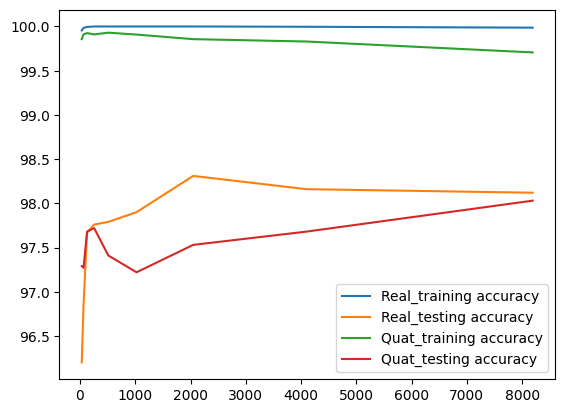

In [7]:
plt.plot(batchsizes,real_accuracies[0],label='Real_training accuracy')
plt.plot(batchsizes,real_accuracies[1],label='Real_testing accuracy')
plt.plot(batchsizes,quat_accuracies[0],label='Quat_training accuracy')
plt.plot(batchsizes,quat_accuracies[1],label='Quat_testing accuracy')
plt.legend()